In [21]:
!pip install 'awswrangler[gremlin, opencypher, sparql]'
!pip install igraph networkx
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 124.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 39.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 27.5 MB/s eta 0:00:00:00:01


In [12]:
from utils.set_env_variables import set_environment_variables
import os

set_environment_variables()

neptune_cluster_id = "neptunedbcluster-gdaeeuitulg4"
neptune_endpoint= os.getenv('NEPTUNE_ENDPOINT')
neptune_port = os.getenv('NEPTUNE_PORT')
neptune_auth_mode = os.getenv('NEPTUNE_AUTH_MODE')
s3_role_arn = os.getenv('S3_ROLE_ARN')
ssl = os.getenv('SSL')
ssl_verify = os.getenv('SSL_VERIFY')
aws_region = os.getenv('AWS_REGION')

In [13]:
import pandas as pd

import awswrangler as wr

url = neptune_endpoint  # The Neptune Cluster endpoint
iam_enabled = False  # Set to True/False based on the configuration of your cluster
neptune_port = 8182  # Set to the Neptune Cluster Port, Default is 8182
client = wr.neptune.connect(url, neptune_port, iam_enabled=iam_enabled)

In [14]:
print(client.status())

{'status': 'healthy', 'startTime': 'Wed Feb 21 00:43:34 UTC 2024', 'dbEngineVersion': '1.3.0.0.R1', 'role': 'writer', 'dfeQueryEngine': 'viaQueryHint', 'gremlin': {'version': 'tinkerpop-3.6.4'}, 'sparql': {'version': 'sparql-1.1'}, 'opencypher': {'version': 'Neptune-9.0.20190305-1.0'}, 'labMode': {'ObjectIndex': 'disabled', 'ReadWriteConflictDetection': 'enabled'}, 'features': {'SlowQueryLogs': 'disabled', 'ResultCache': {'status': 'disabled'}, 'IAMAuthentication': 'disabled', 'Streams': 'disabled', 'AuditLog': 'enabled'}, 'settings': {'clusterQueryTimeoutInMs': '120000', 'SlowQueryLogsThreshold': '5000'}}


In [15]:
query = "g.E().project('source', 'target').by(outV().id()).by(inV().id()).limit(5)"
df = wr.neptune.execute_gremlin(client, query)
display(df.head(5))

,source,target
0,ed98d70ba6e24374aa136fad8a162c5d,account-2199023257128
1,71049bea88004f4bba80d5ee47ad8fc0,account-30786325580428
2,9a835d6c0b92425998d3f1c328300937,account-6597069773744
3,6a8b5644ecca4c68bfdf83f1fcea730b,account-4398046512636
4,1cc89eeb3f384fdbb2e472a5dec3cb22,account-4398046511535


In [16]:
import networkx as nx

# Retrieve Data from neptune
client = wr.neptune.connect(url, 8182, iam_enabled=False)
query = "MATCH (n)-[r]->(d) RETURN id(n) as source, id(d) as target LIMIT 100"
df = wr.neptune.execute_opencypher(client, query)

# Run PageRank
G = nx.from_pandas_edgelist(df, edge_attr=True)
pg = nx.pagerank(G)

# Save values back into Neptune
rows = []
for k in pg.keys():
    rows.append({"~id": k, "pageRank_nx(single)": pg[k]})
pg_df = pd.DataFrame(rows, columns=["~id", "pageRank_nx(single)"])
res = wr.neptune.to_property_graph(client, pg_df, use_header_cardinality=True)

# Retrieve newly saved data
query = (
    "MATCH (n:airport) WHERE n.pageRank_nx IS NOT NULL RETURN n.code, n.pageRank_nx ORDER BY n.pageRank_nx DESC LIMIT 5"
)
df = wr.neptune.execute_opencypher(client, query)
display(df)

""


In [19]:
import uuid
import random

def _create_dummy_triple(s: str = "foo"):
    return {
        "s": s,
        "p": str(uuid.uuid4()),
        "o": random.randint(0, 1000),
    }


label = f"foo_{uuid.uuid4()}"
data = [_create_dummy_triple(label), _create_dummy_triple(label), _create_dummy_triple(label)]
df = pd.DataFrame(data)
res = wr.neptune.to_rdf_graph(client, df)

query = f"SELECT ?p ?o WHERE {{ <{label}> ?p ?o .}}"
df = wr.neptune.execute_sparql(client, query)
display(df)

,p,o
0,http://aws.amazon.com/neptune/default/5197cca2...,http://aws.amazon.com/neptune/default/762
1,http://aws.amazon.com/neptune/default/54da17b4...,http://aws.amazon.com/neptune/default/316
2,http://aws.amazon.com/neptune/default/e7d5f78d...,http://aws.amazon.com/neptune/default/337


['A', 'H', 'G', 'F', 'E']


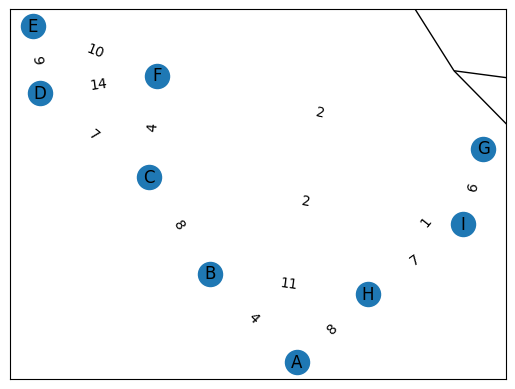

In [23]:
"""
==================
Find Shortest Path
==================

Finding the shortest path between 2 nodes of a given graph
using `shortest_path` function.

"""

import networkx as nx
import matplotlib.pyplot as plt

# Create a graph with nodes and edges
G = nx.Graph()
G.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H"])
G.add_edge("A", "B", weight=4)
G.add_edge("A", "H", weight=8)
G.add_edge("B", "C", weight=8)
G.add_edge("B", "H", weight=11)
G.add_edge("C", "D", weight=7)
G.add_edge("C", "F", weight=4)
G.add_edge("C", "I", weight=2)
G.add_edge("D", "E", weight=9)
G.add_edge("D", "F", weight=14)
G.add_edge("E", "F", weight=10)
G.add_edge("F", "G", weight=2)
G.add_edge("G", "H", weight=1)
G.add_edge("G", "I", weight=6)
G.add_edge("H", "I", weight=7)

# Find the shortest path from node A to node E
path = nx.shortest_path(G, "A", "E", weight="weight")
print(path)

# Create a list of edges in the shortest path
path_edges = list(zip(path, path[1:]))

# Create a list of all edges, and assign colors based on whether they are in the shortest path or not
edge_colors = [
    "red" if edge in path_edges or tuple(reversed(edge)) in path_edges else "black"
    for edge in G.edges()
]

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(u, v): d["weight"] for u, v, d in G.edges(data=True)}
)

plt.show()